In [182]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import statsmodels
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import ols
from scipy import stats

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from tqdm import tqdm
import itertools
from dtw import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import time
from sklearn.metrics import silhouette_score
import csv
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
data_path = '/Users/s0c02nj/Desktop/ML case/data.csv'

In [6]:
df = pd.read_csv(data_path)
df['date_in'] = pd.to_datetime(df['date_in'])

##### Giving the Store Number as Input

In [126]:
#Store_Number
store_no = 84561

In [127]:
h1 = df[df['house_pk'] == store_no]
h1 = h1.sort_values(by='date_in')
h1.head()


,house_pk,agency_id,date_in,price,dis_water_real,dis_shopping,no_bedrooms,max_persons,house_size,land_size,build_year,renovation_year,apartment,indoor_pool,spa,internet,pets_allowed,water_view,fire_stove,agency_rating
151,84561,90,2016-02-06,301,0.261,3.0,3,4,140,726,1953,2014,0,0,1,1,0,1,1,3.0
150,84561,90,2016-02-07,301,0.261,3.0,3,4,140,726,1953,2014,0,0,1,1,0,1,1,3.0
149,84561,90,2016-02-08,301,0.261,3.0,3,4,140,726,1953,2014,0,0,1,1,0,1,1,3.0
148,84561,90,2016-02-09,301,0.261,3.0,3,4,140,726,1953,2014,0,0,1,1,0,1,1,3.0
147,84561,90,2016-02-10,301,0.261,3.0,3,4,140,726,1953,2014,0,0,1,1,0,1,1,3.0


In [148]:
h1['date'] = h1['date_in']
h1 = h1.set_index('date')
timeseries = h1['price'].values

(array([735964., 736085., 736208., 736330., 736450., 736573., 736695.,
        736815., 736938., 737060., 737180.]),
 <a list of 11 Text xticklabel objects>)

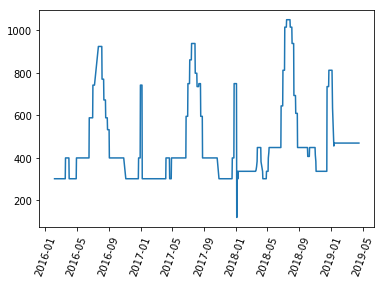

In [149]:
plt.plot(h1['price'])
plt.xticks(rotation=70)


In [152]:
scaler =  MinMaxScaler(feature_range=(0, 1))
timeseries = scaler.fit_transform(np.reshape(timeseries,(-1,1)))

#### Dividing into Train and Test

In [2]:
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[0:train_size,:], timeseries[train_size:len(timeseries),:]
print(len(train), len(test))


Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible.

In [154]:
# fix random seed for reproducibility
np.random.seed(7)

+ The function takes two arguments: the dataset, 
+ which is a NumPy array that we want to convert into a dataset, 
+ and the look_back, which is the number of previous time steps 
+ to use as input variables to predict the next time period — in this case defaulted to 1.


In [155]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [249]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [250]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [251]:
trainX.shape

(879, 1, 5)

In [252]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

In [253]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1,validation_split= 0.1)

Train on 791 samples, validate on 88 samples
Epoch 1/10
791/791 [==============================] - 6s 7ms/step - loss: 0.0204 - val_loss: 0.0274
Epoch 2/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 0.0088
Epoch 3/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 4/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0038 - val_loss: 0.0064
Epoch 5/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 6/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 7/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 8/10
791/791 [==============================] - 3s 3ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 9/10
791/791 [==============================] - 2s 3ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 10/10
791/791 [==============================] - 

In [232]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# # # invert predictions
trainPredict = scaler.inverse_transform(np.reshape(trainPredict,(-1,1)))
trainY = scaler.inverse_transform(np.reshape([trainY],(-1,1)))
testPredict = scaler.inverse_transform(np.reshape(testPredict,(-1,1)))
testY = scaler.inverse_transform(np.reshape([testY],(-1,1)))


#### Train Predictions

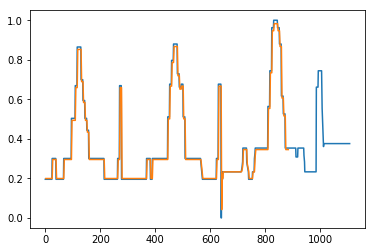

In [233]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(timeseries)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(timeseries)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(timeseries)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(timeseries))
plt.plot(trainPredictPlot)
#plt.xlim(600,690)

#### Test Predictions

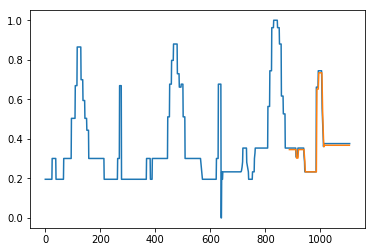

In [234]:
plt.plot(scaler.inverse_transform(timeseries))
plt.plot(testPredictPlot)
plt.show()

#### RMSE Output

In [235]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.04 RMSE


#### Testing the Error Structure

In [236]:
trainPredict.shape

(882, 1)

In [237]:
trainY.shape

(882, 1)

In [238]:
err = trainY - trainPredict

In [247]:
adfTest = adfuller(err[:,0], autolag='AIC')
adfTest[1]

1.8436847796915752e-13

In [248]:
durbin_watson(err[:,0])

1.2468398101031264

#### Conclusion: 
Both the ADF Test and Durbin Watson Test of serial correlation indicates that residuals are iids and hence our model has given stable output.